In [1]:
import pandas as pd
import numpy as np
import requests
import json
import os
from datetime import datetime
import cvxpy as cp
import matplotlib.pyplot as plt

# Parameters
START_DATE = "2010-01-01"
END_DATE = "2024-12-31"

ALPHA = 0.95  # Confidence level for CVaR. ALPHA = 0.95 means we consider the worst 5% of losses.
MAX_WEIGHT = 0.05
ANNUAL_TRADING_DAYS = 252
RISK_FREE_RATE = 0.0
TRANSACTION_COST = 0.001  # 10 bps per side


# Load API key from JSON
with open("api.json", "r") as f:
    API_KEY = json.load(f)["fmp_api_key"]

# Tickers
TICKERS = [line.strip() for line in """AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BK,BKNG,BLK,BMY,BRK.B,C,CAT,CHTR,CL,CMCSA,COF,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,DUK,EMR,FDX,GD,GE,GILD,GM,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDLZ,MDT,MET,META,MMM,MO,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLTR,PM,PYPL,QCOM,RTX,SBUX,SCHW,SO,SPG,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM""".split(",")]
BENCHMARKS = ["OEF", "EQWL"]

print("✅ Step 1 complete: Setup and config loaded.")



✅ Step 1 complete: Setup and config loaded.


In [2]:
# Define a function to fetch historical adjusted close prices from FMP API
def fetch_data(ticker, start, end):
    # Construct API URL with given ticker and date range
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={start}&to={end}&apikey={API_KEY}"
    try:
        response = requests.get(url)
        data = response.json()
        prices = data.get("historical", [])  # Extract price history
        
        # Check if we got any data
        if not prices:
            print(f"⚠️ No data for {ticker}")
            return pd.Series(dtype=float)
        
        # Format data into a DataFrame
        df = pd.DataFrame(prices)
        df["date"] = pd.to_datetime(df["date"])     # Convert date column to datetime
        df = df.set_index("date").sort_index()      # Set date as index and sort chronologically
        
        print(f"✅ Fetched: {ticker}")
        return df["adjClose"]  # Return adjusted close price series
    
    except Exception as e:
        print(f"❌ Failed to fetch {ticker}: {e}")
        return pd.Series(dtype=float)

print("✅ Step 2 complete: Fetch function defined.")



✅ Step 2 complete: Fetch function defined.


In [3]:
# Step 3: Load or fetch historical price data
if not os.path.exists("spx100_prices.csv") or not os.path.exists("benchmarks.csv"):
    print("📥 Downloading price data...")

    # Fetch data for all SPX100 tickers
    data = {ticker: fetch_data(ticker, START_DATE, END_DATE) for ticker in TICKERS}
    prices_df = pd.DataFrame(data).dropna(how="all")  # Drop columns where all data is missing
    prices_df = prices_df.loc[(prices_df.index >= START_DATE) & (prices_df.index <= END_DATE)]
    prices_df.to_csv("spx100_prices.csv", index_label="Date")  # Save to CSV
    print("✅ Saved: spx100_prices.csv")

    # Fetch data for benchmark tickers
    bench_data = {ticker: fetch_data(ticker, START_DATE, END_DATE) for ticker in BENCHMARKS}
    bench_df = pd.DataFrame(bench_data).dropna(how="all")
    bench_df = bench_df.loc[(bench_df.index >= START_DATE) & (bench_df.index <= END_DATE)]
    bench_df.to_csv("benchmarks.csv", index_label="Date")
    print("✅ Saved: benchmarks.csv")

    print("✅ Step 3 complete: Data downloaded, filtered, and saved.")
else:
    # Load from CSV if files already exist
    prices_df = pd.read_csv("spx100_prices.csv", index_col="Date")
    bench_df = pd.read_csv("benchmarks.csv", index_col="Date")

    # Convert string index to datetime
    prices_df.index = pd.to_datetime(prices_df.index)
    bench_df.index = pd.to_datetime(bench_df.index)

    # Filter again just in case
    prices_df = prices_df.loc[(prices_df.index >= START_DATE) & (prices_df.index <= END_DATE)]
    bench_df = bench_df.loc[(bench_df.index >= START_DATE) & (bench_df.index <= END_DATE)]

    print("✅ Step 3 complete: Data loaded and filtered from CSVs.")


✅ Step 3 complete: Data loaded and filtered from CSVs.


📂 Loaded prices data.
📆 Identified 60 quarterly rebalancing periods.

🔄 Rebalancing for period: 2010-03-31 to 2010-06-30
✅ Optimization complete — 94 assets
📈 Stored returns for period.

🔄 Rebalancing for period: 2010-06-30 to 2010-09-30
✅ Optimization complete — 94 assets
💸 Applied transaction cost for turnover: 1.2364
📈 Stored returns for period.

🔄 Rebalancing for period: 2010-09-30 to 2010-12-31
✅ Optimization complete — 95 assets
💸 Applied transaction cost for turnover: 0.8568
📈 Stored returns for period.

🔄 Rebalancing for period: 2010-12-31 to 2011-03-31
✅ Optimization complete — 95 assets
💸 Applied transaction cost for turnover: 1.2437
📈 Stored returns for period.

🔄 Rebalancing for period: 2011-03-31 to 2011-06-30
✅ Optimization complete — 96 assets


/tmp/ipykernel_53019/4278835524.py:9: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_starts = prices_df.resample("Q").first().index


💸 Applied transaction cost for turnover: 1.4408
📈 Stored returns for period.

🔄 Rebalancing for period: 2011-06-30 to 2011-09-30
✅ Optimization complete — 96 assets
💸 Applied transaction cost for turnover: 1.0299
📈 Stored returns for period.

🔄 Rebalancing for period: 2011-09-30 to 2011-12-31
✅ Optimization complete — 96 assets
💸 Applied transaction cost for turnover: 0.7000
📈 Stored returns for period.

🔄 Rebalancing for period: 2011-12-31 to 2012-03-31
✅ Optimization complete — 96 assets
💸 Applied transaction cost for turnover: 0.6887
📈 Stored returns for period.

🔄 Rebalancing for period: 2012-03-31 to 2012-06-30
✅ Optimization complete — 96 assets
💸 Applied transaction cost for turnover: 1.1462
📈 Stored returns for period.

🔄 Rebalancing for period: 2012-06-30 to 2012-09-30
✅ Optimization complete — 96 assets
💸 Applied transaction cost for turnover: 1.2036
📈 Stored returns for period.

🔄 Rebalancing for period: 2012-09-30 to 2012-12-31
✅ Optimization complete — 98 assets
💸 Applied 

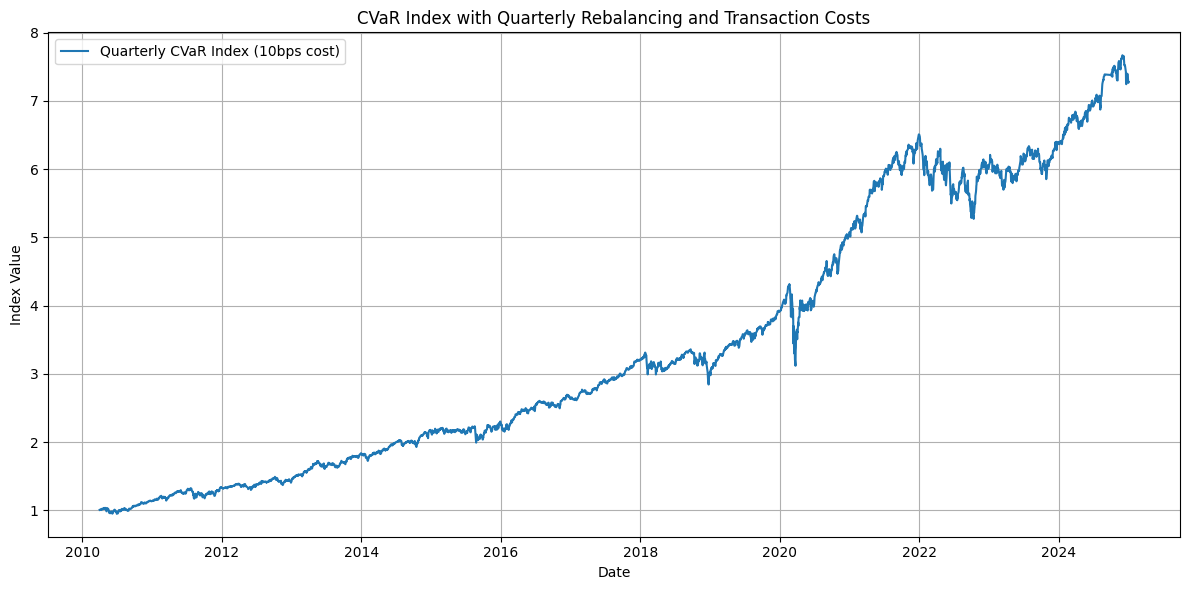

📉 Plot displayed.


In [4]:

# Load data
prices_df = pd.read_csv("spx100_prices.csv", index_col="Date", parse_dates=True)
print("📂 Loaded prices data.")




# Quarterly rebalancing dates
quarter_starts = prices_df.resample("Q").first().index
print(f"📆 Identified {len(quarter_starts)} quarterly rebalancing periods.")

# ⚠️ NOTE: Strategy starts in March 2010 (Q2) due to needing 3-month lookback from Jan 1, 2010


cvar_returns = []
prev_weights = None
prev_assets = None

for i in range(len(quarter_starts) - 1):
    start_date = quarter_starts[i]
    end_date = quarter_starts[i + 1]

    print(f"\n🔄 Rebalancing for period: {start_date.date()} to {end_date.date()}")

    # Lookback period: 3 months prior
    lookback_start = start_date - pd.DateOffset(months=3)
    lookback_data = prices_df.loc[lookback_start:start_date].dropna(axis=1, thresh=60)

    if lookback_data.shape[1] < 2:
        print(f"⏭️ Skipped — not enough valid stocks ({lookback_data.shape[1]})")
        continue

    returns = lookback_data.pct_change().dropna()
    R = returns.values
    n = R.shape[1]
    N_samples = R.shape[0]

    # CVaR optimization setup
    w = cp.Variable(n)
    z = cp.Variable(N_samples)
    t = cp.Variable()
    losses = -R @ w
    objective = t + (1 / ((1 - ALPHA) * N_samples)) * cp.sum(z)
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w <= MAX_WEIGHT,
        z >= losses - t,
        z >= 0
    ]
    prob = cp.Problem(cp.Minimize(objective), constraints)

    try:
        prob.solve(solver=cp.ECOS)
    except:
        print(f"❌ Solver failed for {start_date.date()}")
        continue

    weights = w.value
    assets = lookback_data.columns
    print(f"✅ Optimization complete — {n} assets")

    # Forward returns
    forward_prices = prices_df.loc[start_date:end_date, assets].dropna()
    forward_returns = forward_prices.pct_change().dropna()
    quarter_returns = forward_returns @ weights

    # Apply transaction cost at rebalancing
    if prev_weights is not None:
        aligned_weights = np.zeros_like(weights)
        for j, asset in enumerate(assets):
            if asset in prev_assets:
                prev_index = list(prev_assets).index(asset)
                aligned_weights[j] = prev_weights[prev_index]
        turnover = np.sum(np.abs(weights - aligned_weights))
        quarter_returns.iloc[0] -= turnover * TRANSACTION_COST
        print(f"💸 Applied transaction cost for turnover: {turnover:.4f}")

    prev_weights = weights
    prev_assets = assets
    cvar_returns.append(quarter_returns)
    print(f"📈 Stored returns for period.")

# Combine returns and build index
cvar_full_returns = pd.concat(cvar_returns).sort_index()
cvar_index = (1 + cvar_full_returns).cumprod()
cvar_index.name = "CVaR Index (with Txn Cost)"
print("📊 Index constructed.")

# Save index
cvar_index.to_csv("cvar_index_quarterly_txn_cost.csv")
print("💾 Index saved to cvar_index_quarterly_txn_cost.csv")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(cvar_index.index, cvar_index, label="Quarterly CVaR Index (10bps cost)")
plt.title("CVaR Index with Quarterly Rebalancing and Transaction Costs")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print("📉 Plot displayed.")


In [16]:
# 📥 Load CVaR Index (with transaction costs)
cvar_index = pd.read_csv("cvar_index_quarterly_txn_cost.csv", index_col="Date", parse_dates=True)
cvar_index = cvar_index.squeeze()  # Ensure it's a Series
optimized_returns = cvar_index.pct_change().dropna()

# 📊 Define metrics calculation function
def metrics(index_series, return_series):
    index_series = index_series.squeeze()
    return_series = return_series.squeeze()

    cumulative_return = index_series.iloc[-1] / index_series.iloc[0] - 1
    annual_return = (index_series.iloc[-1] / index_series.iloc[0]) ** (ANNUAL_TRADING_DAYS / len(index_series)) - 1
    annual_vol = return_series.std() * np.sqrt(ANNUAL_TRADING_DAYS)
    sharpe = (annual_return - RISK_FREE_RATE) / annual_vol if annual_vol != 0 else np.nan
    cvar = np.percentile(return_series, 5)
    max_dd = ((index_series / index_series.cummax()) - 1).min()

    return {
        "Cumulative Return": cumulative_return,
        "Annual Return": annual_return,
        "Volatility": annual_vol,
        "Sharpe": sharpe,
        "95% CVaR": cvar,
        "Max Drawdown": max_dd
    }

# 🧮 Calculate metrics for CVaR Index
results = {"CVaR Index": metrics(cvar_index, optimized_returns)}

# 📥 Load and align benchmark data once
aligned_start = cvar_index.index.min()
aligned_end = cvar_index.index.max()

bench_df = pd.read_csv("benchmarks.csv", index_col="Date", parse_dates=True)
bench_df = bench_df.loc[(bench_df.index >= aligned_start) & (bench_df.index <= aligned_end)]

# 📈 Calculate metrics for each benchmark
for b in BENCHMARKS:
    b_prices = bench_df[b].dropna()
    b_prices = b_prices.loc[(b_prices.index >= aligned_start) & (b_prices.index <= aligned_end)]
    b_returns = b_prices.pct_change().fillna(0)
    b_index = (1 + b_returns).cumprod()
    results[b] = metrics(b_index, b_returns)
    print(f"{b} dates: {b_prices.index.min().date()} to {b_prices.index.max().date()}")

# 📋 Display summary table
print("📊 Step 5 complete: Metrics calculated.")
summary_df = pd.DataFrame(results).T.round(4)
display(summary_df)



OEF dates: 2010-04-01 to 2024-12-31
EQWL dates: 2010-04-01 to 2024-12-31
📊 Step 5 complete: Metrics calculated.


,Cumulative Return,Annual Return,Volatility,Sharpe,95% CVaR,Max Drawdown
CVaR Index,6.2302,0.1454,0.1404,1.0358,-0.0129,-0.2766
OEF,6.0149,0.1414,0.1723,0.8202,-0.0165,-0.3143
EQWL,4.9959,0.1293,0.1627,0.7944,-0.0152,-0.3430


In [12]:
# 🗓️ Calculate yearly returns for CVaR and benchmarks
def calc_yearly_returns(series):
    return series.resample('Y').last().pct_change().dropna()

yearly_returns = {
    "CVaR Index": calc_yearly_returns(cvar_index)
}

for b in BENCHMARKS:
    b_series = bench_df[b].dropna()
    b_series = b_series.loc[(b_series.index >= aligned_start) & (b_series.index <= aligned_end)]
    b_index = (1 + b_series.pct_change().fillna(0)).cumprod()
    yearly_returns[b] = calc_yearly_returns(b_index)

yearly_df = pd.DataFrame(yearly_returns)
display(yearly_df.style.format("{:.2%}").set_caption("📆 Yearly Returns"))


/tmp/ipykernel_53019/2898239213.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  return series.resample('Y').last().pct_change().dropna()
/tmp/ipykernel_53019/2898239213.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  return series.resample('Y').last().pct_change().dropna()
/tmp/ipykernel_53019/2898239213.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  return series.resample('Y').last().pct_change().dropna()


,CVaR Index,OEF,EQWL
Date,,,
2011-12-31 00:00:00,17.47%,2.79%,2.99%
2012-12-31 00:00:00,6.97%,15.93%,11.76%
2013-12-31 00:00:00,28.86%,30.06%,37.32%
2014-12-31 00:00:00,16.80%,12.57%,15.15%
2015-12-31 00:00:00,5.48%,2.41%,-2.34%
2016-12-31 00:00:00,16.24%,11.28%,13.34%
2017-12-31 00:00:00,21.67%,21.82%,24.40%
2018-12-31 00:00:00,-5.29%,-4.16%,-6.31%
2019-12-31 00:00:00,29.25%,31.86%,29.55%


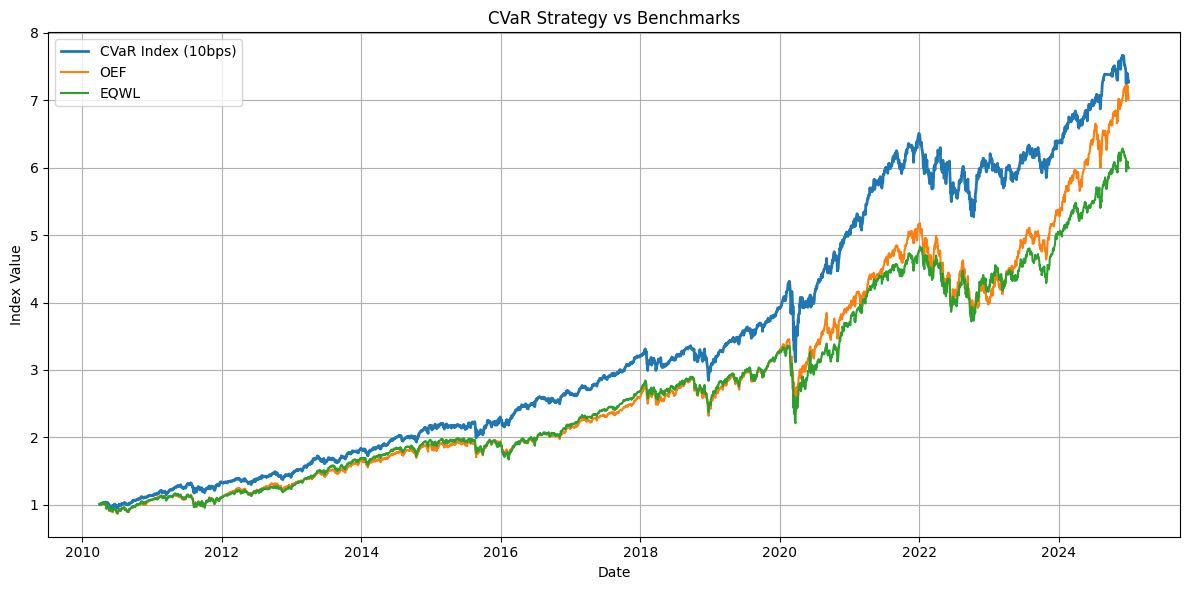

📈 Step 6 complete: CVaR vs Benchmark comparison chart displayed.


In [15]:
# 📅 Filter CVaR index to match overall timeframe
cvar_index = cvar_index.loc[(cvar_index.index >= aligned_start) & (cvar_index.index <= aligned_end)]

# Rebuild benchmark indices
benchmark_indices = {}
for b in BENCHMARKS:
    b_prices = bench_df[b].dropna()
    b_prices = b_prices.loc[(b_prices.index >= aligned_start) & (b_prices.index <= aligned_end)]
    b_returns = b_prices.pct_change().fillna(0)
    b_index = (1 + b_returns).cumprod()
    benchmark_indices[b] = b_index

# Plot
plt.figure(figsize=(12, 6))
plt.plot(cvar_index.index, cvar_index.values, label="CVaR Index (10bps)", linewidth=2)

for b, b_index in benchmark_indices.items():
    plt.plot(b_index.index, b_index.values, label=b)

plt.title("CVaR Index vs Benchmarks (Mar 2010 to Dec 2024, Cumulative Returns)")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend(title="Strategy / Benchmark")
plt.grid(True)
plt.tight_layout()
plt.show()

print("📈 Step 6 complete: CVaR vs Benchmark comparison chart displayed.")


In [14]:
# Ensure the variable is named correctly
cvar_full_returns.name = "CVaR_Strategy_Returns"

# Save the daily returns to CSV
cvar_full_returns.to_csv("cvar_strategy_daily_returns.csv", index=True)

print("✅ Step 8 complete: Exported CVaR strategy daily returns to 'cvar_strategy_daily_returns.csv'")



✅ Step 8 complete: Exported CVaR strategy daily returns to 'cvar_strategy_daily_returns.csv'


In [17]:
yearly_returns = optimized_returns.resample("Y").apply(lambda r: (1 + r).prod() - 1)
yearly_returns.index = yearly_returns.index.year
print(yearly_returns)

# 📌 Note: Strategy starts from March 2010 due to 3-month lookback period for CVaR optimization


Date
2010    0.127364
2011    0.174702
2012    0.069724
2013    0.288590
2014    0.168029
2015    0.054842
2016    0.162381
2017    0.216669
2018   -0.052908
2019    0.292492
2020    0.295676
2021    0.281013
2022   -0.071083
2023    0.058913
2024    0.137378
Name: CVaR Index (with Txn Cost), dtype: float64


/tmp/ipykernel_53019/1018834942.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_returns = optimized_returns.resample("Y").apply(lambda r: (1 + r).prod() - 1)
